# Survival analysis - understanding the principles

In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=300)
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.datasets import *

# Without any right-censored data

Right-censored data is where subjects in the "trial" do not suffer an "event" (e.g., death, default, ...) during the trial. As such, they are still "alive" after the end of the trial. This fact must be accounted for when estimating the survival probability.

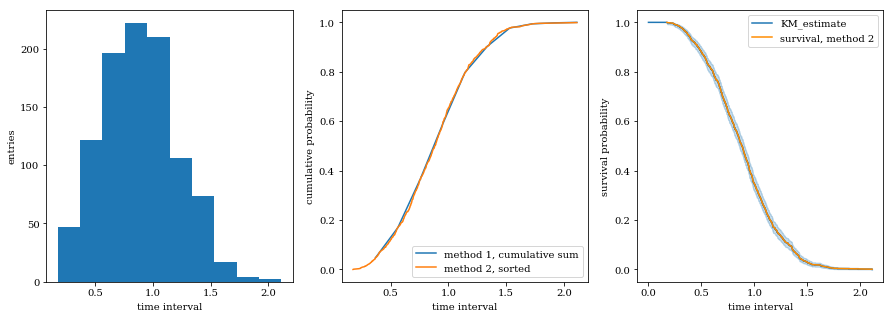

In [3]:
N = 1000
Z = np.random.weibull(3,N)

# method 1
H,X1 = np.histogram( Z, bins = 10, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
# method 2
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

# survival
kmf = KaplanMeierFitter()
# We don't see any "events" beyond the end of the study
kmf.fit(Z, event_observed=np.ones(len(Z)))  # or, more succiently, kmf.fit(T, E)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].hist(Z, bins = 10)
axs[0].set_xlabel("time interval")
axs[0].set_ylabel("entries")
axs[1].plot(X1[1:], F1, label='method 1, cumulative sum')
axs[1].plot(X2, F2, label='method 2, sorted')
axs[1].set_xlabel("time interval")
axs[1].set_ylabel("cumulative probability")
axs[1].legend()
kmf.plot(ax=axs[2])
axs[2].plot(X2, 1-F2, label='survival, method 2',c='darkorange')
axs[2].set_xlabel("time interval")
axs[2].set_ylabel("survival probability")
axs[2].legend()
plt.show()

# Now use a dataset with a small fraction of right-censored data

In [4]:
df = load_waltons()
df.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [5]:
df.shape

(163, 3)

In [6]:
df.E.sum()

156

In [7]:
df[df.E<1]

,T,E,group
39,61.0,0,control
41,61.0,0,control
54,69.0,0,control
71,68.0,0,control
89,7.0,0,control
144,45.0,0,control
152,60.0,0,control


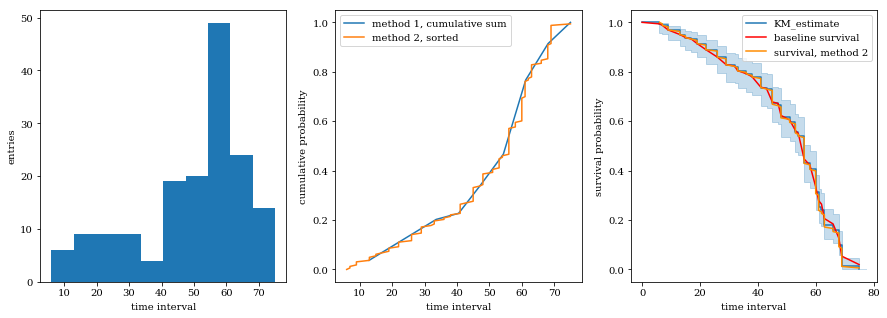

In [8]:
# method 1
H,X1 = np.histogram( df['T'], bins = 10, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx

# method 2
X2 = np.sort(df['T'])
F2 = np.array(range(df.shape[0]))/float(df.shape[0])

# Kaplan-Meier survival
kmf.fit(df['T'], df['E']) 

#from lifelines import NelsonAalenFitter
#naf = NelsonAalenFitter()
#naf.fit(df['T'], df['E']) # shows the hazard function

# Cox
cph = CoxPHFitter()
cph.fit(df.drop(['group'], axis=1), 'T', event_col='E')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].hist(df['T'], bins = 10)
axs[0].set_xlabel("time interval")
axs[0].set_ylabel("entries")
axs[1].plot(X1[1:], F1, label='method 1, cumulative sum')
axs[1].plot(X2, F2, label='method 2, sorted')
axs[1].set_xlabel("time interval")
axs[1].set_ylabel("cumulative probability")
axs[1].legend()
kmf.plot(ax=axs[2], label = 'Kaplan-Meier estimate')
cph.baseline_survival_.plot(ax=axs[2],c='red',label = 'Cox estimate')
axs[2].plot(X2, 1-F2, label='survival, method 2',c='darkorange')
axs[2].set_xlabel("time interval")
axs[2].set_ylabel("survival probability")
axs[2].legend()

In [9]:
kmf.predict([10,20])

10    0.964580
20    0.905419
Name: KM_estimate, dtype: float64

# Use different dataset where large fraction of the events are censored (i.e., no "event" is observed)

In [10]:
df = load_gbsg2()
df.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


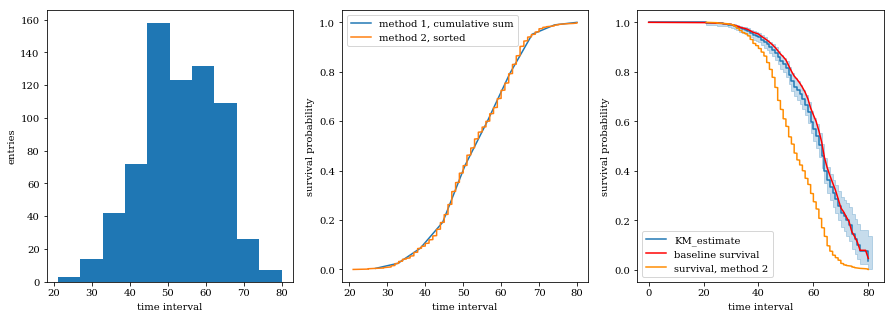

In [11]:
# method 1
H,X1 = np.histogram( df['age'], bins = 10, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx

# method 2
X2 = np.sort(df['age'])
F2 = np.array(range(df.shape[0]))/float(df.shape[0])

# Kaplan-Meier survival
kmf.fit(df['age'], df['cens']) 

#from lifelines import NelsonAalenFitter
#naf = NelsonAalenFitter()
#naf.fit(df['T'], df['E']) # shows the hazard function

# Cox
cph = CoxPHFitter()
cph.fit(df.drop(['horTh','menostat','tgrade'], axis=1), 'age', event_col='cens')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].hist(df['age'], bins = 10)
axs[0].set_xlabel("time interval")
axs[0].set_ylabel("entries")
axs[1].plot(X1[1:], F1, label='method 1, cumulative sum')
axs[1].plot(X2, F2, label='method 2, sorted')
axs[1].set_xlabel("time interval")
axs[1].set_ylabel("survival probability")
axs[1].legend()
kmf.plot(ax=axs[2], label = 'Kaplan-Meier estimate')
cph.baseline_survival_.plot(ax=axs[2],c='red',label = 'Cox estimate')
axs[2].plot(X2, 1-F2, label='survival, method 2',c='darkorange')
axs[2].set_xlabel("time interval")
axs[2].set_ylabel("survival probability")
axs[2].legend()

# Regression

Now we can use the model to predict the survival probability for a particular test data point (i.e., a person)

In [12]:
cph.print_summary()

n=686, number of events=299

           coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
tsize    0.0086     1.0086    0.0041  2.0743 0.0381      0.0005      0.0167    *
pnodes  -0.0102     0.9898    0.0096 -1.0698 0.2847     -0.0290      0.0085     
progrec -0.0007     0.9993    0.0004 -1.5471 0.1218     -0.0015      0.0002     
estrec  -0.0017     0.9983    0.0005 -3.4998 0.0005     -0.0026     -0.0007  ***
time    -0.0009     0.9991    0.0001 -8.3893 0.0000     -0.0012     -0.0007  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.711
Likelihood ratio test = 139.076 on 5 df, p=0.00000


This is just a plot of the parameter estimates, with their standard deviation

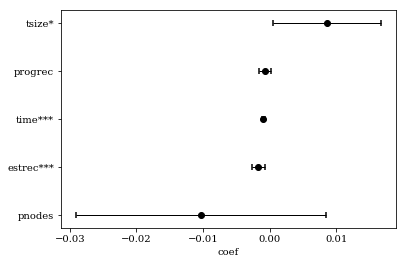

In [13]:
cph.plot()

In [14]:
# test data point
data  = {'age': [50],
         'tsize': [21],
         'pnodes': [3],
         'progrec': [48],
         'estrec': [66],
         'time': [1814],
         'cens': [1],
        }
test = pd.DataFrame.from_dict(data)

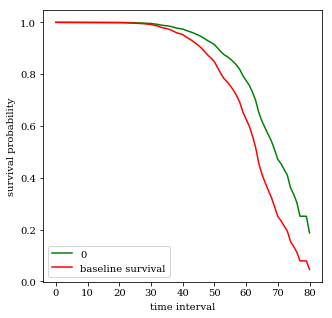

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
cph.predict_survival_function(test).plot(ax=ax,c='green')  # get the unique survival functions of two subjects
cph.baseline_survival_.plot(ax=ax, c='red')
ax.set_xlabel("time interval")
ax.set_ylabel("survival probability")
ax.legend()